In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyimpute import load_training_vector, load_targets, impute, evaluate_clf
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import classification_report

import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
import re
import string
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from numpy.random import permutation

/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
from torch import cuda
device = 'cuda:2' if cuda.is_available() else 'cpu'

In [4]:
###1.3 Set GPU Growth -> avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
#ia toate GPUs disponibile pe aceasta masina

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
full_data=pd.read_csv('../datasets/mental_disorders_reddit_preprossed.csv')

In [6]:
full_data=full_data.dropna(axis=0).reset_index(drop=True)

In [7]:
full_data['selftext'].head()

0    anyon els think import part life relationship ...
1    hello fellow friend  im bpd spectrum discourag...
2    f20 bf m20 tell today say  wish could better  ...
3    okay  open mani thing  do past  proud  person ...
4    without go detail diagnosi explain much sudden...
Name: selftext, dtype: object

In [8]:
full_data['subreddit'].unique()

array(['BPD', 'bipolar', 'depression', 'Anxiety', 'schizophrenia',
       'mentalillness'], dtype=object)

In [9]:
X=full_data["selftext"]
y=full_data["subreddit"].values

X_train, X_test, y_train, y_test = train_test_split (X,y,test_size=0.3, random_state=42, stratify=y )

In [10]:
X_train

483495    littl background 19f sever anxieti issu creat ...
94183     parent give love support anyon condit could as...
432760    think attempt suicid past 12 month volunt need...
55792     realli need support advic get infatu everyon m...
201995                                                delet
                                ...                        
357990    actual cant even face anoth day fake world lie...
325568    may last post idk  expect  hope someon see act...
385943    make account tell would decent place ask get c...
68820     hello diagnos bpd 17 10 year ago  overcom lot ...
282956    english nativ languag sorri mistak make dont k...
Name: selftext, Length: 404003, dtype: object

In [11]:
labels_uniq=np.unique(y)

In [13]:
#vectorization tfidf
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)

X_train_tfidf = tfidf.fit_transform(X_train.astype('U')).toarray()
X_test_tfidf = tfidf.transform(X_test.astype('U')).toarray()

In [12]:
def class_weight_compute(labels_dict,mu=0.2):
    print(labels_dict)
    total = np.sum(labels_dict[1])
    keys = labels_dict[0]

    weight = dict()
    for i in range(len(labels_dict[0])):
        score = np.log(mu*total/float(labels_dict[1][i]))
        print(i,score)
        weight[i] = score if score > 1 else 1
    return weight
# random labels_dict
labels_dict =np.unique(y_train,return_counts=True)
weights = class_weight_compute(labels_dict)
weights

(array(['Anxiety', 'BPD', 'bipolar', 'depression', 'mentalillness',
       'schizophrenia'], dtype=object), array([112634, 148213,  24795,  83880,  26391,   8090]))
0 -0.3321592327034849
1 -0.6066660370710661
2 1.181342371300956
3 -0.03740281479166582
4 1.118961348303406
5 2.301355660171653


{0: 1,
 1: 1,
 2: 1.181342371300956,
 3: 1,
 4: 1.118961348303406,
 5: 2.301355660171653}

In [13]:
#model
def train_model(model,XTrain,ytrain,XTest,ytest):
    model.fit(XTrain, ytrain)    
    
    y_pred = model.predict(XTest)
    y_prob = model.predict_proba(XTest)
    accuracy = round(accuracy_score(ytest, y_pred),3)
    precision = round(precision_score(ytest, y_pred,average="micro"),3)
    recall = round(recall_score(ytest, y_pred,average="micro"),3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1)
    fig, ax = plt.subplots(1, 2, figsize = (25,  10))
    ax1 = plot_confusion_matrix(ytest, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation='vertical')
    ax2 = plot_roc(ytest, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')
    
    
    print(classification_report(ytest, y_pred))

Accuracy of the model: 0.66
Precision Score of the model: 0.66
Recall Score of the model: 0.66
               precision    recall  f1-score   support

      Anxiety       0.73      0.74      0.73     48272
          BPD       0.62      0.87      0.72     63520
      bipolar       0.71      0.30      0.42     10626
   depression       0.67      0.54      0.60     35949
mentalillness       0.48      0.01      0.02     11311
schizophrenia       0.74      0.13      0.21      3467

     accuracy                           0.66    173145
    macro avg       0.66      0.43      0.45    173145
 weighted avg       0.66      0.66      0.63    173145



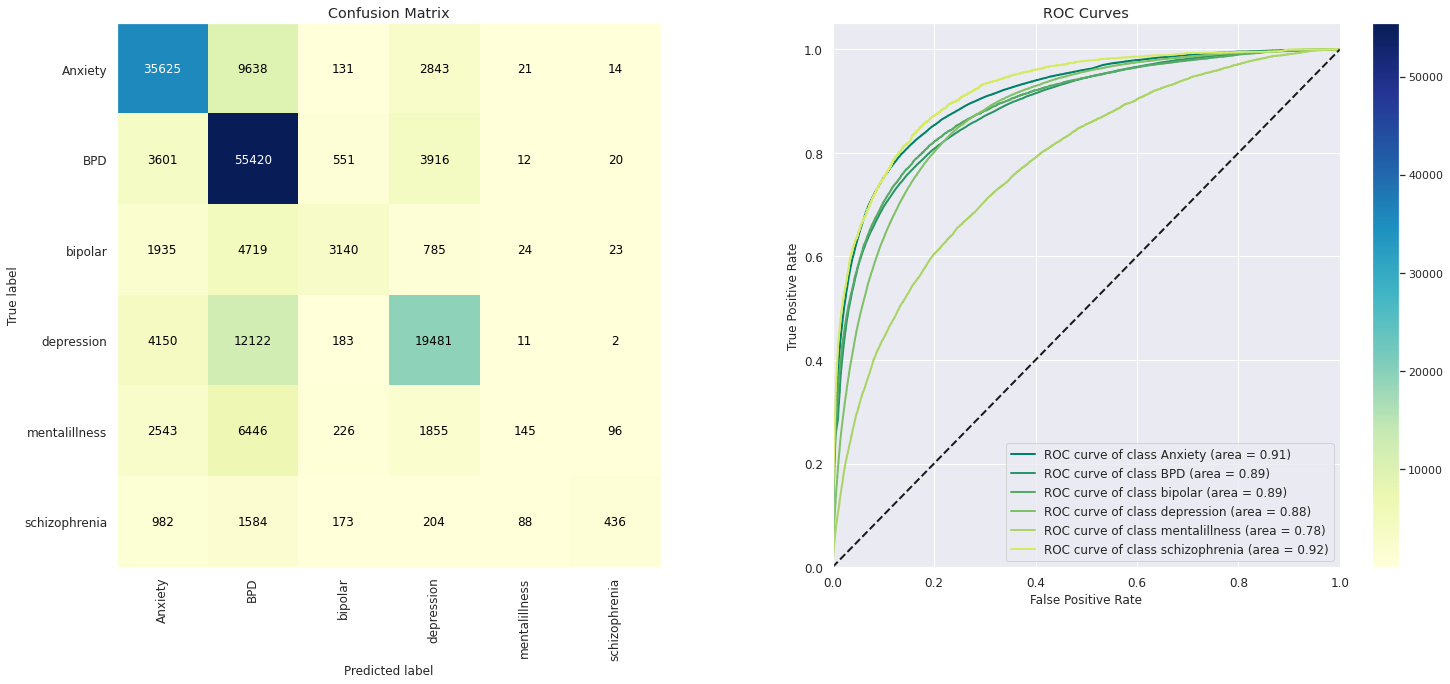

In [16]:
nb = MultinomialNB()
train_model(nb,X_train_tfidf,y_train,X_test_tfidf,y_test)

Accuracy of the model: 0.714
Precision Score of the model: 0.714
Recall Score of the model: 0.714
               precision    recall  f1-score   support

      Anxiety       0.76      0.82      0.79     48272
          BPD       0.71      0.85      0.78     63520
      bipolar       0.76      0.47      0.58     10626
   depression       0.64      0.66      0.65     35949
mentalillness       0.56      0.05      0.10     11311
schizophrenia       0.71      0.24      0.36      3467

     accuracy                           0.71    173145
    macro avg       0.69      0.52      0.54    173145
 weighted avg       0.71      0.71      0.69    173145



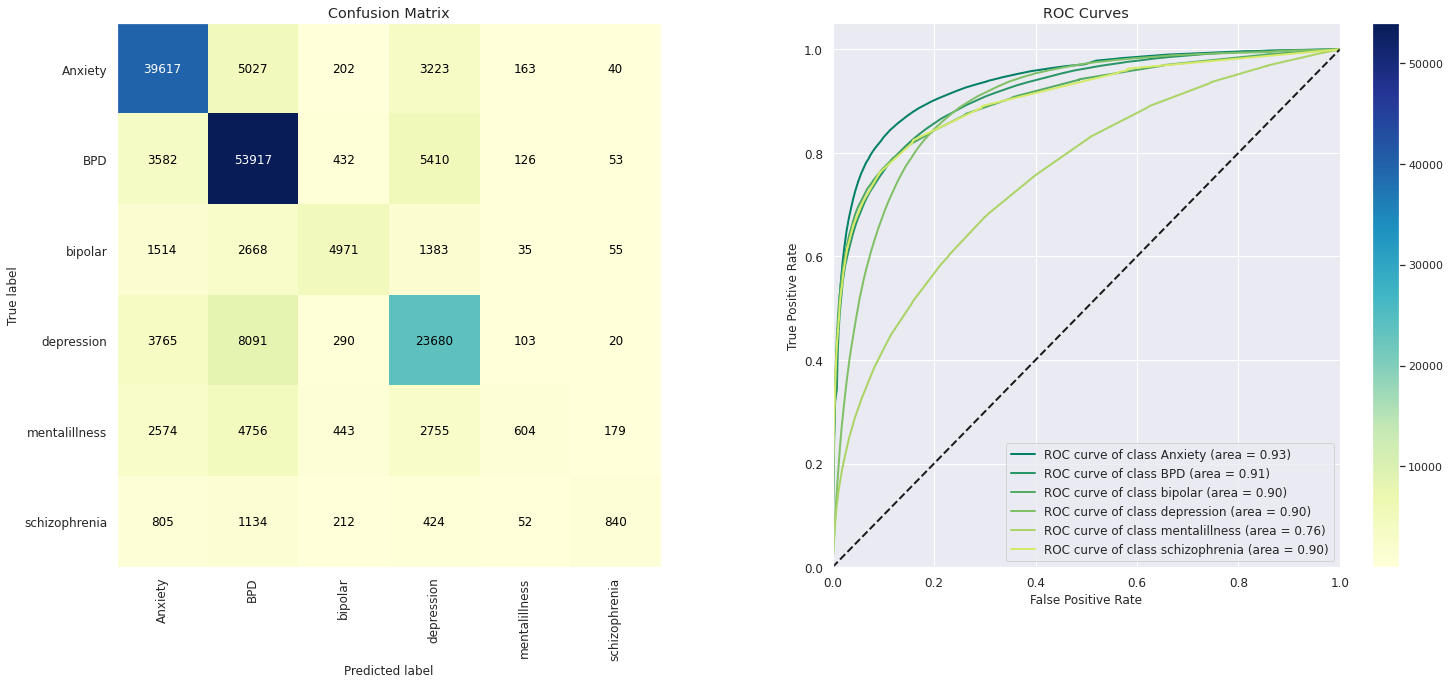

In [17]:
rf = RandomForestClassifier(n_estimators= 100)
train_model(rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

In [18]:
from sklearn.tree import export_graphviz
estimator = rf.estimators_[0]

# Export as dot file
export_graphviz(estimator, max_depth=2,
                out_file='tree.dot',
                class_names = list(full_data['subreddit'].unique()),
                rounded = True, proportion = False, 
                precision = 2, filled = True)


In [19]:
# Convert to png7
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

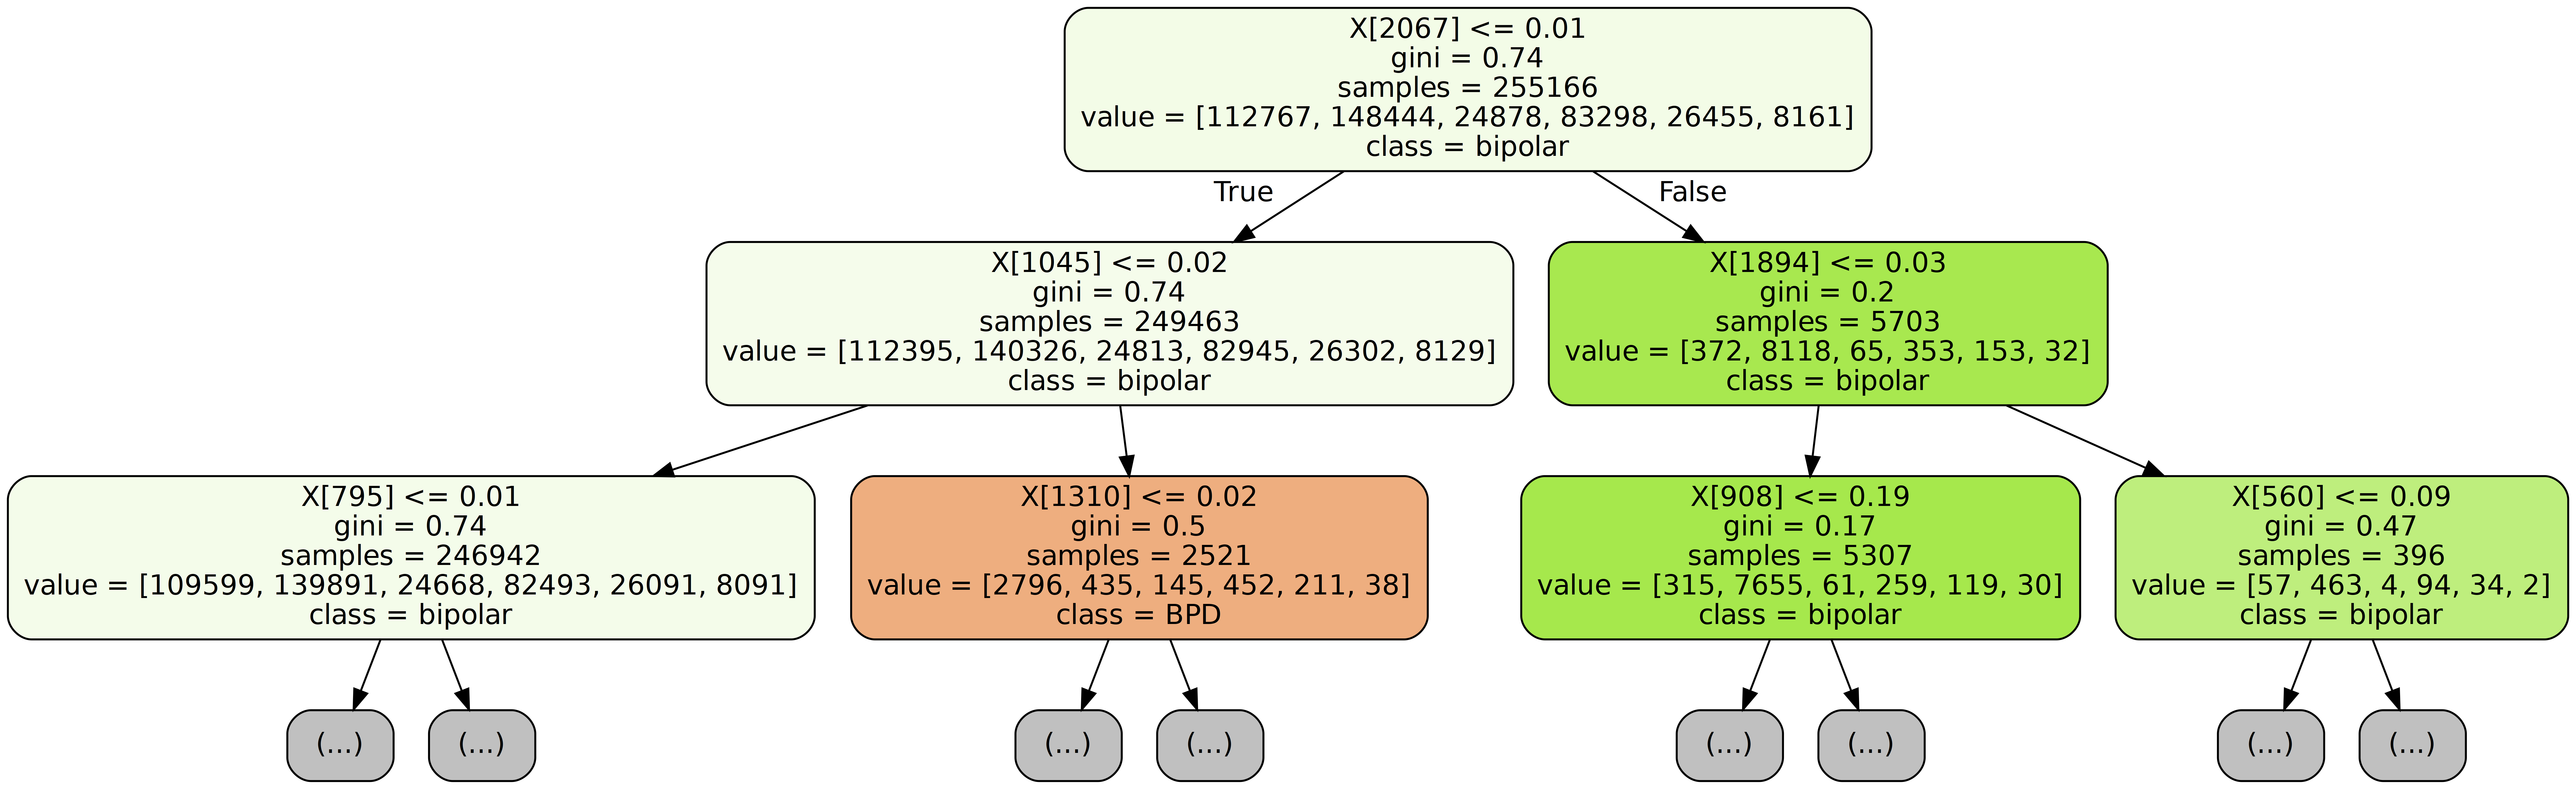

In [20]:
from IPython.display import Image
Image(filename = 'tree.png')

In [15]:
#vectorization glove embeddings
from tqdm import tqdm

In [16]:
total_vocabulary=set()
for tweet in full_data['selftext']:
   if(type(tweet)!=float):
    prep=tweet.split()
    for word in prep:
        total_vocabulary.add(word)


In [17]:
embedding_vector = {}
f = open('../datasets/glove.6B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    if word in total_vocabulary:
        coef = np.array(value[1:],dtype = 'float32')
        embedding_vector[word] = coef

400000it [00:14, 27820.57it/s]


In [18]:
class GloveVectorizer(object):
    def __init__(self,w2v):
        self.w2v=w2v
        if(len(w2v) == 0):
            self.dimensions=0
        else:
            self.dimensions=len(w2v[next(iter(embedding_vector))])
    def fit(self,X,y):
        return self
    def transform(self,X):
        
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v] or [np.zeros(self.dimensions)],axis=0) for words in X
        ])
        

In [19]:
vectorizer_glove=GloveVectorizer(embedding_vector)

In [20]:
X_glove=vectorizer_glove.transform(full_data['selftext'])

In [21]:
X_train_glove, X_test_glove,y_train_glove,y_test_glove=train_test_split(X_glove,y,test_size=0.3,random_state=1)

Accuracy of the model: 0.493
Precision Score of the model: 0.493
Recall Score of the model: 0.493
               precision    recall  f1-score   support

      Anxiety       0.54      0.59      0.57     48149
          BPD       0.48      0.75      0.58     63502
      bipolar       0.43      0.02      0.04     10576
   depression       0.43      0.24      0.31     36377
mentalillness       0.54      0.02      0.04     11175
schizophrenia       0.65      0.04      0.08      3366

     accuracy                           0.49    173145
    macro avg       0.51      0.28      0.27    173145
 weighted avg       0.49      0.49      0.44    173145



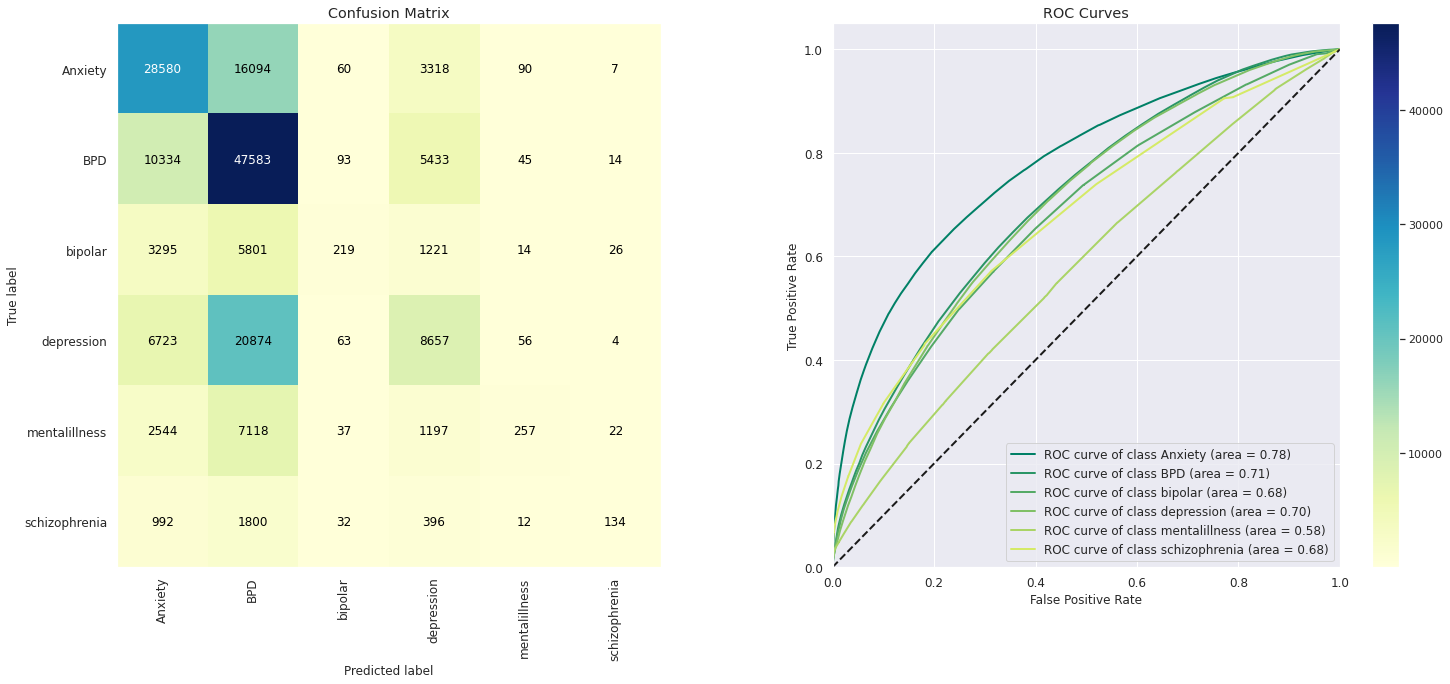

In [22]:
rf = RandomForestClassifier(random_state=1)
train_model(rf,X_train_glove,y_train_glove,X_test_glove,y_test_glove)

In [23]:
X_train_pos=X_train_glove
X_test_pos=X_test_glove

In [24]:
X_train_pos=(X_train_pos - X_train_pos.min()) / (X_train_pos.max() - X_train_pos.min())
X_test_pos=(X_test_pos - X_test_pos.min()) / (X_test_pos.max() - X_test_pos.min())


In [25]:
y_train_glove

array(['depression', 'BPD', 'BPD', ..., 'Anxiety', 'Anxiety', 'BPD'],
      dtype=object)

Accuracy of the model: 0.367
Precision Score of the model: 0.367
Recall Score of the model: 0.367
               precision    recall  f1-score   support

      Anxiety       0.00      0.00      0.00     48149
          BPD       0.37      1.00      0.54     63502
      bipolar       0.00      0.00      0.00     10576
   depression       0.00      0.00      0.00     36377
mentalillness       0.00      0.00      0.00     11175
schizophrenia       0.00      0.00      0.00      3366

     accuracy                           0.37    173145
    macro avg       0.06      0.17      0.09    173145
 weighted avg       0.13      0.37      0.20    173145



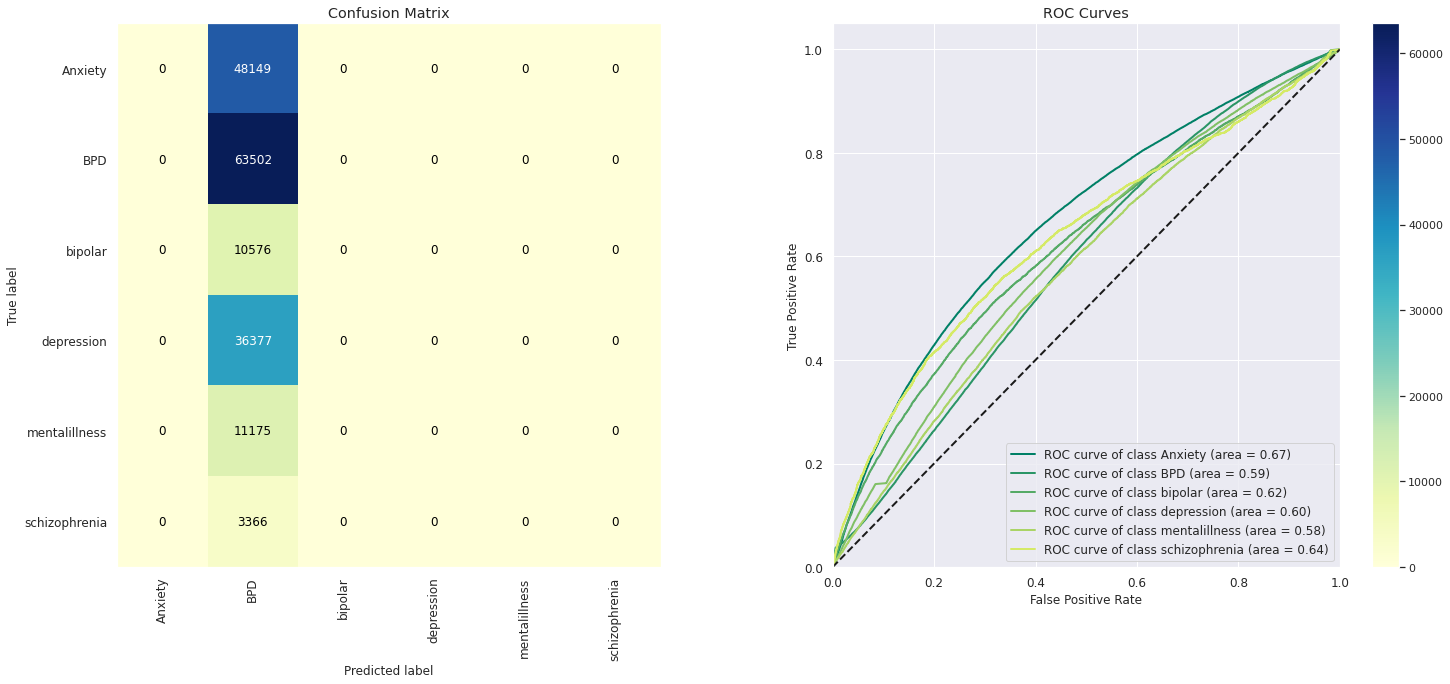

In [26]:
nb = MultinomialNB()
train_model(nb,X_train_pos,y_train_glove,X_test_pos,y_test_glove)